In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os

In [2]:
def random_image(val_dir,val_class):
    folder = val_dir + val_class
    random_image = random.sample(os.listdir(folder),1)
    img = mping.imread(folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(val_class)
    return img

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
#from tensorflow.keras.layers import LeakyReLU

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "/kaggle/input/skin-diseases/kaggle_v2/kaggle/train"
test_dir =  "/kaggle/input/skin-diseases/kaggle_v2/kaggle/test"
val_dir = "/kaggle/input/skin-diseases/kaggle_v2/kaggle/val"

train_data = image_dataset_from_directory(train_dir,label_mode = "categorical", image_size = (600,600),batch_size = 16, shuffle = True,seed = 42)
test_data = image_dataset_from_directory(test_dir,label_mode = "categorical", image_size = (600,600),batch_size = 16, shuffle = False,seed = 42)
val_data = image_dataset_from_directory(val_dir,label_mode = "categorical", image_size = (600,600),batch_size = 16, shuffle = False,seed = 42)

Found 30909 files belonging to 6 classes.
Found 3928 files belonging to 6 classes.
Found 3923 files belonging to 6 classes.


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 5, min_delta = 0.0001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 4, min_lr = 1e-7)

In [6]:
from tensorflow.keras.layers.experimental import preprocessing
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    #preprocessing.RandomBrightness(factor=0.2),
    preprocessing.RandomContrast(factor=0.2),
    preprocessing.RandomFlip("vertical"),
],name = "data_augmentation_layer")

In [7]:
model = tf.keras.applications.EfficientNetB7(include_top = False, weights='imagenet')
model.trainable = False

258076736/258076736 [==============================] - 9s 0us/step


In [8]:
inputs = layers.Input(shape = (600,600,3),name = "input_layer")
x = data_aug(inputs)
x = model(x)
x = layers.GlobalAvgPool2D(name = "pooling_layer")(x)
# katmandan üretilen çıktının boyutunu belirtmek için kullanılan parametre.
#x = layers.Dense(128,activation = "relu",kernel_initializer = tf.keras.initializers.he_normal())(x)
x = layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6)(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)
model = tf.keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 600, 600, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 pooling_layer (GlobalAverag  (None, 2560)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [9]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [10]:
history = model.fit(train_data,epochs =20, validation_data = val_data, callbacks = [early_stop,reduce_lr])

Epoch 1/20


2023-04-29 10:58:03.990678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1932/1932 [==============================] - 2134s 1s/step - loss: 0.8730 - accuracy: 0.6530 - val_loss: 0.8125 - val_accuracy: 0.6865 - lr: 0.0010
Epoch 2/20
1932/1932 [==============================] - 2111s 1s/step - loss: 0.7714 - accuracy: 0.6930 - val_loss: 0.7286 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 3/20
1932/1932 [==============================] - 2099s 1s/step - loss: 0.7284 - accuracy: 0.7137 - val_loss: 0.6875 - val_accuracy: 0.7392 - lr: 0.0010
Epoch 4/20
1932/1932 [==============================] - 2107s 1s/step - loss: 0.6973 - accuracy: 0.7265 - val_loss: 0.6950 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 5/20
1932/1932 [==============================] - 2092s 1s/step - loss: 0.6761 - accuracy: 0.7353 - val_loss: 0.6608 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 6/20
1932/1932 [==============================] - 2126s 1s/step - loss: 0.6574 - accuracy: 0.7419 - val_loss: 0.6544 - val_accuracy: 0.7453 - lr: 0.0010
Epoch 7/20
1932/1932 [==============================] - 2

In [11]:
print("Testing Accuracy",model.evaluate(test_data))

246/246 [==============================] - 193s 783ms/step - loss: 0.4899 - accuracy: 0.8208
Testing Accuracy [0.4899483025074005, 0.8207739591598511]


In [12]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='En İyi Öğrenme Adımı: '+ str(index_loss+1 +start_epoch)
    vc_label='En İyi Öğrenme Adımı: '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Eğitim Kaybı')
    axes[0].plot(Epochs,vloss,'g',label='Doğrulama Kaybı' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Eğitim ve Doğrulama Kayıpları')
    axes[0].set_xlabel('Öğrenme Adımları (Epochs)')
    axes[0].set_ylabel('Kayıplar (Loss)')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Eğitim Başarımı (Training Accuricy)')
    axes[1].plot (Epochs,vacc,'g',label= 'Doğrulama Başarımı (Validation Accuracy)')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Eğitim ve Doğrulama Başarımı')
    axes[1].set_xlabel('Öğrenme Adımları (Epochs)')
    axes[1].set_ylabel('Doğruluk (Accuracy)')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

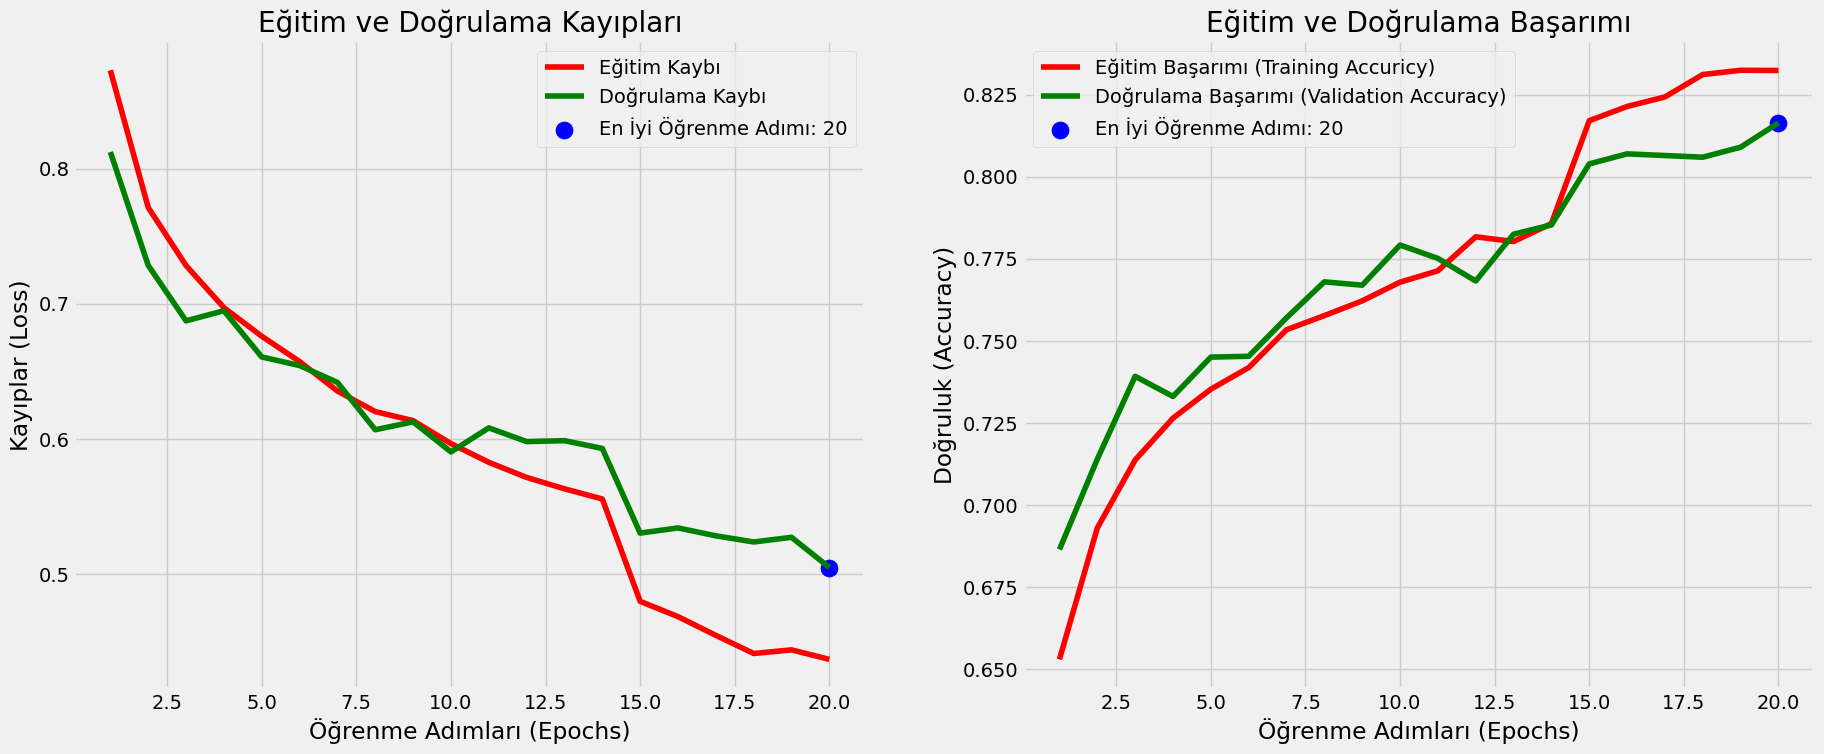

In [13]:
import numpy as np
tr_plot(history,0)

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [15]:
y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
y_labels[:20]
print(len(y_labels))

3928


In [16]:
pred_probs = model.predict(test_data)
pred_probs[0]

246/246 [==============================] - 195s 773ms/step


array([0.290043  , 0.50084484, 0.00643039, 0.00195821, 0.08907539,
       0.11164813], dtype=float32)

In [17]:
pred_classes = pred_probs.argmax(axis =1)
print(pred_classes[0])
class_names = train_data.class_names
print(class_names[pred_classes[3]])

1
2. Ekzama


In [18]:
from sklearn.metrics import classification_report
print("Sınıflandırma Raporu\n",classification_report(y_labels,pred_classes))

Sınıflandırma Raporu
               precision    recall  f1-score   support

           0       0.79      0.80      0.80       750
           1       0.74      0.79      0.76       510
           2       0.91      0.85      0.88       322
           3       0.94      0.57      0.71       136
           4       0.83      0.91      0.87      1361
           5       0.84      0.75      0.79       849

    accuracy                           0.82      3928
   macro avg       0.84      0.78      0.80      3928
weighted avg       0.82      0.82      0.82      3928



In [19]:
classification_dict = classification_report(y_labels,pred_classes,output_dict = True)
classification_dict

{'0': {'precision': 0.794973544973545,
  'recall': 0.8013333333333333,
  'f1-score': 0.798140770252324,
  'support': 750},
 '1': {'precision': 0.7425925925925926,
  'recall': 0.7862745098039216,
  'f1-score': 0.7638095238095238,
  'support': 510},
 '2': {'precision': 0.9075907590759076,
  'recall': 0.8540372670807453,
  'f1-score': 0.8800000000000001,
  'support': 322},
 '3': {'precision': 0.9390243902439024,
  'recall': 0.5661764705882353,
  'f1-score': 0.7064220183486238,
  'support': 136},
 '4': {'precision': 0.8262032085561497,
  'recall': 0.9081557678177811,
  'f1-score': 0.8652432621631081,
  'support': 1361},
 '5': {'precision': 0.844207723035952,
  'recall': 0.7467608951707891,
  'f1-score': 0.7925000000000001,
  'support': 849},
 'accuracy': 0.8207739307535642,
 'macro avg': {'precision': 0.8424320364130082,
  'recall': 0.7771230406324676,
  'f1-score': 0.80101926242893,
  'support': 3928},
 'weighted avg': {'precision': 0.8238540850688486,
  'recall': 0.8207739307535642,
  'f

In [20]:
classification_f1_scores = {}
for k,v in classification_dict.items():
    if k == "accuracy":
        break
    else:
        classification_f1_scores[class_names[int(k)]] = v["f1-score"]
classification_f1_scores

{'1. Enfeksiyonel': 0.798140770252324,
 '2. Ekzama': 0.7638095238095238,
 '3. Akne': 0.8800000000000001,
 '4. Pigment': 0.7064220183486238,
 '5. Benign': 0.8652432621631081,
 '6. Malign': 0.7925000000000001}

In [21]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name":list(classification_f1_scores.keys()), "F1-Scores":list(classification_f1_scores.values())})
f1_scores.sort_values("F1-Scores",ascending = False)

,class_name,F1-Scores
2,3. Akne,0.880000
4,5. Benign,0.865243
0,1. Enfeksiyonel,0.798141
5,6. Malign,0.792500
1,2. Ekzama,0.763810
3,4. Pigment,0.706422


In [22]:
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Hata Matrisi (Confusion Matrix)",
         xlabel="Tahmin Edilen (Predicted)",
         ylabel="Gerçek Veri",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

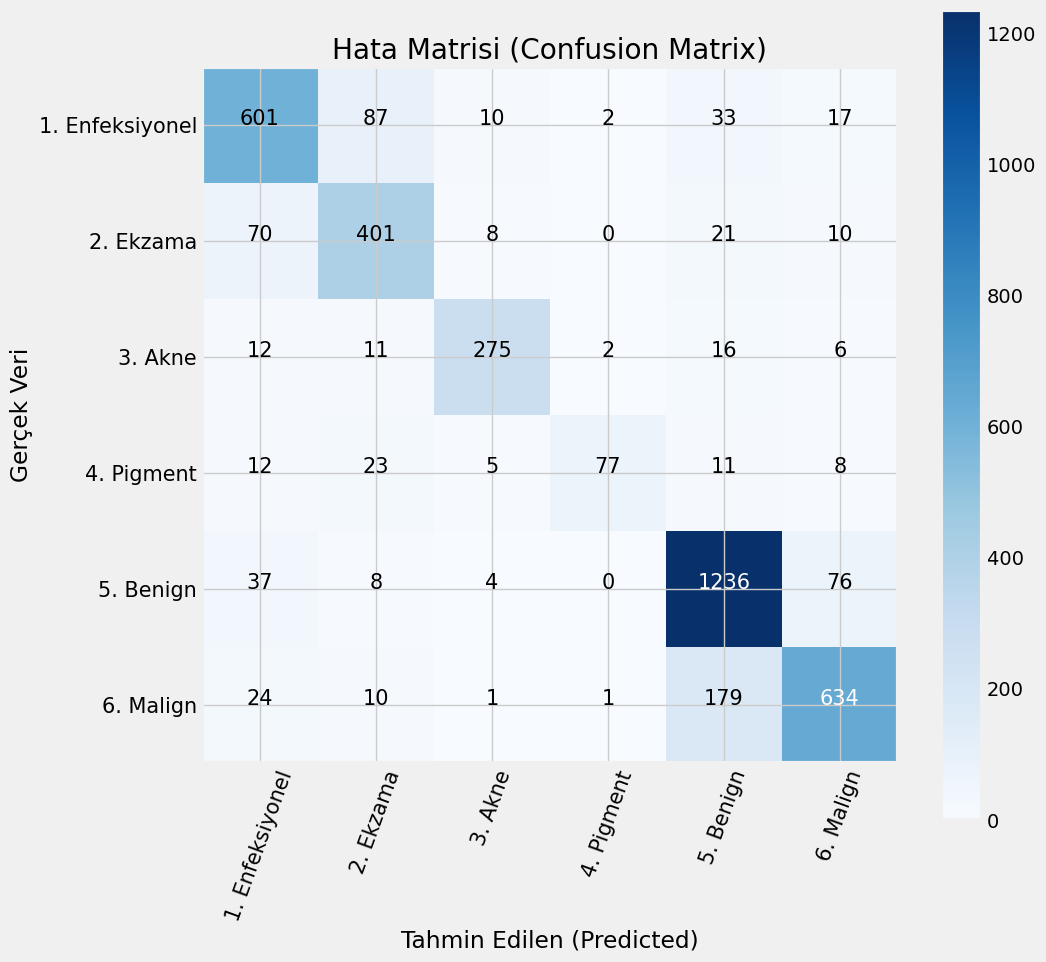

In [23]:
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))

In [24]:
#model.save('my-model.h5')

In [25]:
tf.saved_model.save(model, 'my-model-relu-wndb16d256')

In [26]:
import shutil
shutil.make_archive('my-model-relu-wndb16d256', 'zip', '/kaggle/working/my-model-relu-wndb16d256')

'/kaggle/working/my-model-relu-wndb16d256.zip'

<a href="kaggle/working/my-model.zip"> Download File </a>


In [27]:
#loaded_model = tf.saved_model.load('/kaggle/working/my-model')

In [28]:
#import cv2
#import shutil

#img_path=r'/kaggle/input/skin-diseases/kaggle/test/2. Ekzama/03EczemaAreolae021223.jpg'
#img = cv2.imread(img_path)
#img = cv2.resize(img,(600,600))
#img = img.reshape(1,600,600,3)
#predictions = model(x)

In [29]:
# 'serving_default' imzasını al
#inference = loaded_model.signatures['serving_default']
#infer = loaded_model.signatures["serving_default"]


# Resim yükleme
#image = tf.keras.preprocessing.image.load_img(
#    '/kaggle/input/skin-diseases/kaggle/test/2. Ekzama/03EczemaAreolae021223.jpg', target_size=(600, 600)
#)
#image = tf.keras.preprocessing.image.img_to_array(image)
#image = tf.keras.applications.efficientnet.preprocess_input(image)

# Tahmin et
#output = inference(tf.constant(image), training=False)['output_1']

#output = loaded_model(input_tensor)
#prediction = tf.constant(output['activation'])
#print(prediction)

In [30]:
#print(dir(loaded_model))

In [31]:
#print(loaded_model.signatures)

In [32]:
#def predict_image(image_path, model):
    # Resim dosyasını yükleme
#    img = Image.open(image_path)
    # Resmi modelin beklentisi olan boyuta yeniden boyutlandırma
#    img = img.resize((600, 600))
    # Resmi numpy dizisine dönüştürme
#    img_array = np.array(img)
    # Resmi 0-1 aralığına ölçeklendirme
#    img_array = img_array / 255.0
    # Tahmin etme
#    signature = tf.saved_model.load('/kaggle/working/my-model').signatures['serving_default']
 #   input_layer = tf.constant(img_array, dtype=tf.float32)
#    result = signature(input_layer=input_layer)['output_layer']
#    predicted_class = tf.argmax(result, axis=-1).numpy()[0]
#    return predicted_class

In [33]:
#predict_image('/kaggle/input/skin-diseases/kaggle/test/2. Ekzama/03EczemaAreolae021223.jpg', loaded_model)